In [1]:
import os
import yaml
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import random

# Import required components from your project
from data_loader import load_and_segment_data, SensorDataset, train_val_test_split
from models.cnn_model import CNNModel
from models.lstm import LSTMModel
from models.rnn import VanillaRNNModel
from models.ntflstm import LSTMAutoregressive

# -------------------------------
# CONFIGURATION & DATA LOADING
# -------------------------------
# Load configuration from YAML file
config_path = os.path.join("config", "forshaking.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
column_names = ["Gyroscope X", "Gyroscope Y","Gyroscope Z", "Acceleration X","Acceleration Y","Acceleration Z"]

# Load data (using training set for visualization; adjust data_dir as needed)
X, y, labels = load_and_segment_data(
    data_dir="dataset/train",
    window_size=config['window_size'],
    predict_size=config['predict_size'],
    balance_config=config
)

X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = train_val_test_split(
    X, y, labels, test_size=0.2, val_size=0.4, random_state=38
)

# Create the training dataset (normalization is applied in SensorDataset)
train_dataset = SensorDataset(X_train, y_train, normalize=True)
test_dataset = SensorDataset (X_test, y_test,labels = labels_test, normalize = True)
val_dataset = SensorDataset(X_val,y_val,labels = labels_val, normalize = True)
#train_dataset = SensorDataset(X_train, y_train, labels=X_train_labels, normalize=True)

# -------------------------------
# MODEL LOADING
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config["model_type"] == "cnn":
    model = CNNModel(window_size=config['window_size'],
                 predict_size=config['predict_size'],
                 num_features=6)
elif config["model_type"] == "lstm":
        model = LSTMModel(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
elif config["model_type"] == "ntflstm":
        model = LSTMAutoregressive(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
elif config["model_type"] == "rnn":
        model = VanillaRNNModel(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
model_path = config.get('model_save_path', "./output_model/forshaking.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()



/var/folders/1b/x02b24d16rbf3gjfvngp6hqw0000gn/T/ipykernel_77235/1645907398.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

VanillaRNNModel(
  (rnn): RNN(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=180, bias=True)
)

In [2]:

import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def visualize_new_grouped_sensors(sample, model, config, device):
    """
    Visualizes predictions for sensor groups:
      - Gyroscope Sensor: channels 0,1,2
      - Acceleration Sensor: channels 3,4,5
    Stacks these two plots vertically into one figure.
    The time axis is scaled by dividing by 10.
    Places the category label at the top-right of the first subplot.
    """
    # -------------------------------
    # UNPACK & GET PREDICTIONS
    # -------------------------------
    try:
        sample_X, sample_y, category = sample
    except ValueError:
        sample_X, sample_y = sample
        category = "Unknown"
    sample_X = sample_X.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred_y = model(sample_X)

    # Move back to CPU and squeeze
    sample_X = sample_X.cpu().numpy().squeeze()  # (window_size, 6)
    sample_y = sample_y.cpu().numpy().squeeze()  # (predict_size, 6)
    pred_y   = pred_y.cpu().numpy().squeeze()    # (predict_size, 6)
    
    window_size  = config['window_size']
    predict_size = config['predict_size']

    # Original time axes
    time_axis_input = np.arange(window_size)
    time_axis_pred  = np.arange(window_size, window_size + predict_size)

    # Scale the time axes by dividing by 10
    time_axis_input_scaled = time_axis_input / 10.0
    time_axis_pred_scaled  = time_axis_pred  / 10.0
    loss_value = np.mean((pred_y - sample_y)**2)
    # -------------------------------
    # PLOTTING SETUP
    # -------------------------------
    # Create a single figure with two subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    # Reduce the vertical spacing between subplots
    fig.subplots_adjust(hspace=0.0)  

    # Define colors for x, y, z
    colors = [(220/255, 100/255, 100/255),
              (245/255, 151/255, 66/255),
              (84/255, 150/255, 206/255)]
    g_channel_labels = [r'$g_x$', r'$g_y$', r'$g_z$']
    a_channel_labels = [r'$a_x$', r'$a_y$', r'$a_z$']
    mpl.rcParams['font.size'] = 22          # Global font size for all text
    mpl.rcParams['axes.labelsize'] = 22     # Font size for x- and y-labels
    mpl.rcParams['axes.titlesize'] = 22     # Font size for subplot titles
    mpl.rcParams['legend.fontsize'] = 23    # Font size for legend
    mpl.rcParams['xtick.labelsize'] = 26    # Font size for x tick labels
    mpl.rcParams['ytick.labelsize'] = 26 
    legend_props = {'family': 'Arial'}
    grid_kwargs = dict(color='white', linewidth=0)

    shadow = True  # Enable shaded prediction region

    # -------------------------------
    # SUBPLOT 1: GYROSCOPE
    # -------------------------------
    for idx in range(3):
        ax1.plot(time_axis_input_scaled, sample_X[:, idx],
                 color=colors[idx], linewidth=2)
        ax1.plot(time_axis_pred_scaled,  sample_y[:, idx],
                 color=colors[idx], linestyle='-', marker='o', markersize=4)
        ax1.plot(time_axis_pred_scaled,  pred_y[:, idx],
                 color=colors[idx], linestyle=':', marker='x', markersize=4)
        
        # Connecting line from last input to first ground truth value
        ax1.plot([time_axis_input_scaled[-1], time_axis_pred_scaled[0]],
                 [sample_X[-1, idx], sample_y[0, idx]],
                 color=colors[idx], linestyle='-', linewidth=2)

    # Shaded region for predictions (if enabled)
    if shadow:
        ax1.axvspan(time_axis_input_scaled[-1], time_axis_pred_scaled[-1],
                    facecolor=(188/255, 150/255, 120/255), alpha=0.1)

    # Build combined legend handles for gyroscope subplot
    sensor_handles = [Line2D([0], [0], color=colors[i], lw=2, label=g_channel_labels[i])
                      for i in range(3)]
    style_handles = [
        Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=4, label='ground truth'),
        Line2D([0], [0], color='black', linestyle=':', marker='x', markersize=4, label='predicted data')
    ]
    combined_handles = sensor_handles + style_handles
    if shadow:
        shadow_handle = Patch(facecolor=(188/255,150/255,120/255), alpha=0.1, label='predict')
        combined_handles.append(shadow_handle)

    ax1.legend(handles=combined_handles, loc='upper left', frameon=False, prop=legend_props, ncol = 2)
    ax1.set_ylabel("Gyroscope " + r'$(^\circ ~ \mathrm{s}^{-1})$')
    ax1.yaxis.set_label_coords(-0.12, 0.5)
    ax1.grid(True, **grid_kwargs)

    # Place the category label at the top-right of the first subplot
    ax1.text(0.95, 0.95, f'{category.capitalize()}',
             transform=ax1.transAxes, ha='right', va='top')

    # -------------------------------
    # SUBPLOT 2: ACCELERATION
    # -------------------------------
    for idx in range(3):
        ch = idx + 3  # channels for acceleration
        ax2.plot(time_axis_input_scaled, sample_X[:, ch],
                 color=colors[idx], linewidth=2)
        ax2.plot(time_axis_pred_scaled,  sample_y[:, ch],
                 color=colors[idx], linestyle='-', marker='o', markersize=4)
        ax2.plot(time_axis_pred_scaled,  pred_y[:, ch],
                 color=colors[idx], linestyle=':', marker='x', markersize=4)
        
        # Connecting line for acceleration
        ax2.plot([time_axis_input_scaled[-1], time_axis_pred_scaled[0]],
                 [sample_X[-1, ch], sample_y[0, ch]],
                 color=colors[idx], linestyle='-', linewidth=2)

    if shadow:
        ax2.axvspan(time_axis_input_scaled[-1], time_axis_pred_scaled[-1],
                    facecolor=(188/255,150/255,120/255), alpha=0.1)

    # Build combined legend handles for acceleration subplot
    sensor_handles_a = [Line2D([0], [0], color=colors[i], lw=2, label=a_channel_labels[i])
                        for i in range(3)]
    style_handles_a = [
        Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=4, label='ground truth'),
        Line2D([0], [0], color='black', linestyle=':', marker='x', markersize=4, label='predicted data')
    ]
    combined_handles_a = sensor_handles_a + style_handles_a
    if shadow:
        shadow_handle_a = Patch(facecolor=(188/255,150/255,120/255), alpha=0.1, label='predict')
        combined_handles_a.append(shadow_handle_a)

    ax2.legend(handles=combined_handles_a, loc='lower left', frameon=False, prop=legend_props,ncol = 2)
    ax2.set_ylabel("Acceleration " + r'$(\mathrm{m} ~ \mathrm{s}^{-2})$')
    ax2.yaxis.set_label_coords(-0.12, 0.5)
    ax2.set_xlabel("Time (s)")
    ax2.grid(True, **grid_kwargs)
    ax1.tick_params(axis='both', which='both', width=3, length=8)
    ax2.tick_params(axis='both', which='both', width=3, length=8)
    ax2.set_xlabel("Time (s)", fontsize=28)

    # Make spines thicker if desired
    for spine in ax1.spines.values():
        spine.set_linewidth(3)
    for spine in ax2.spines.values():
        spine.set_linewidth(3)

    plt.show()
    return loss_value


In [3]:
def extract_samples_by_label(dataset_train, dataset_test, dataset_val, target_label):
    # Combine all datasets
    combined = dataset_train + dataset_test + dataset_val
    # Filter only those samples that have at least 3 elements and a matching label (case-insensitive)
    filtered = []
    for sample in combined:
        if len(sample) >= 3:
            label = sample[2]
            if isinstance(label, str) and label.lower() == target_label.lower():
                filtered.append(sample)
    return filtered

In [4]:
#shaking_samples = extract_samples_by_label(train_dataset, test_dataset, val_dataset, "shaking")

Grouped visualization for test sample index: 0


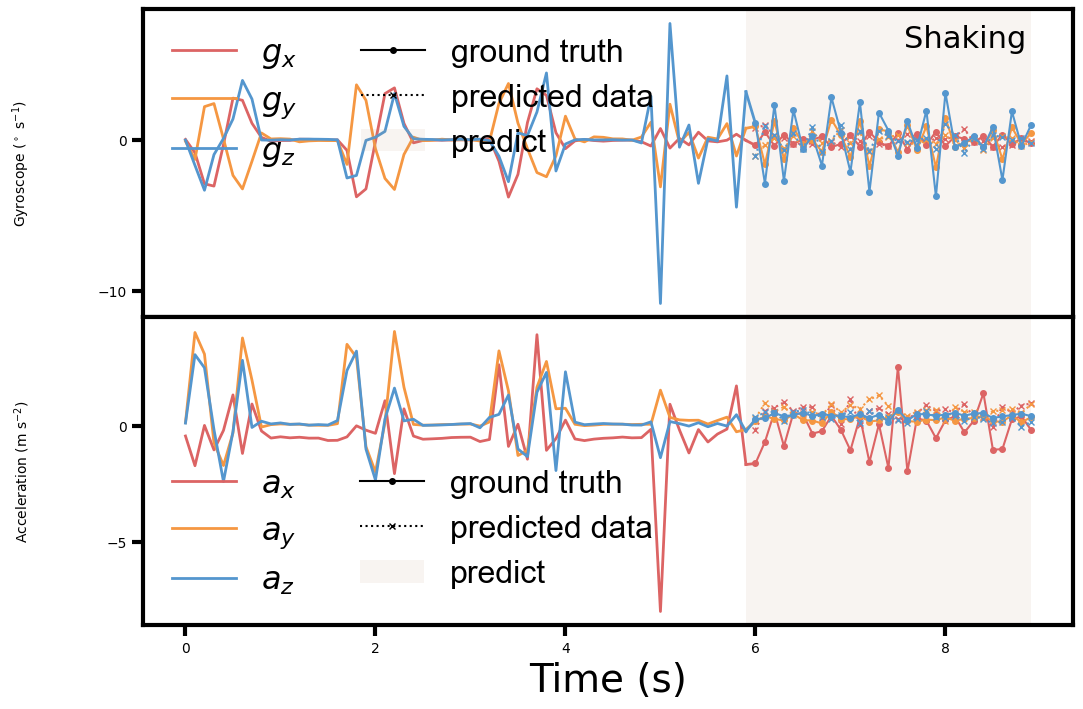

Loss: 0.9581698775291443
Grouped visualization for test sample index: 1


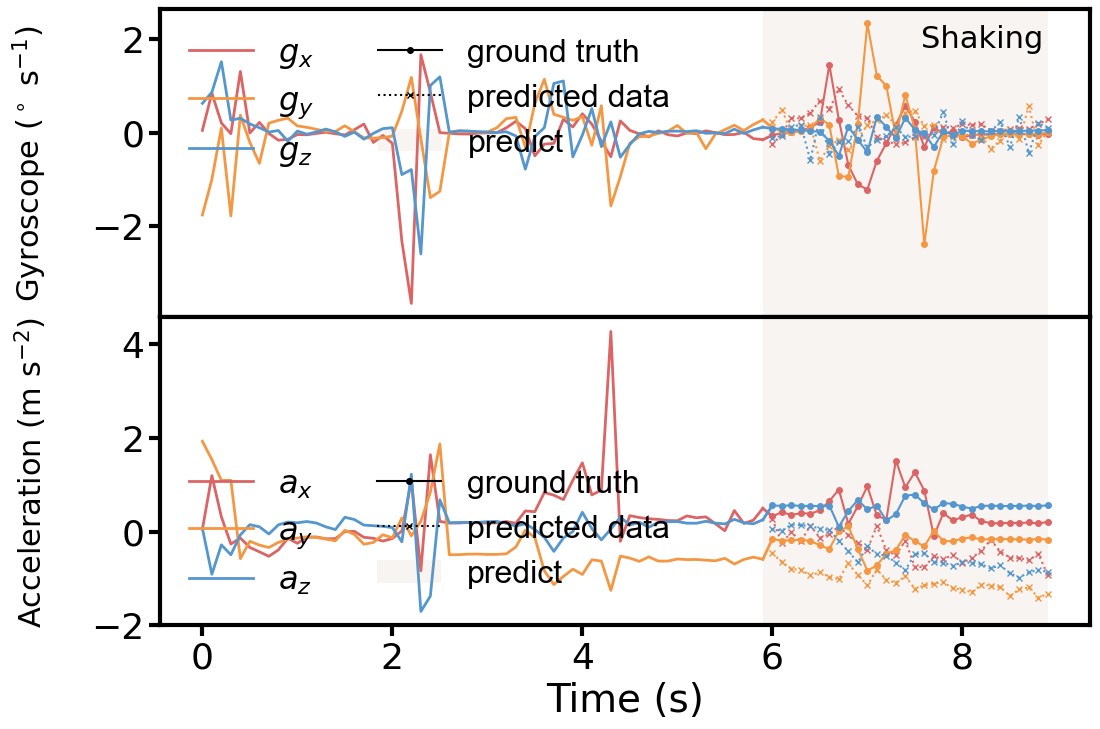

Loss: 0.6228942275047302
Grouped visualization for test sample index: 2


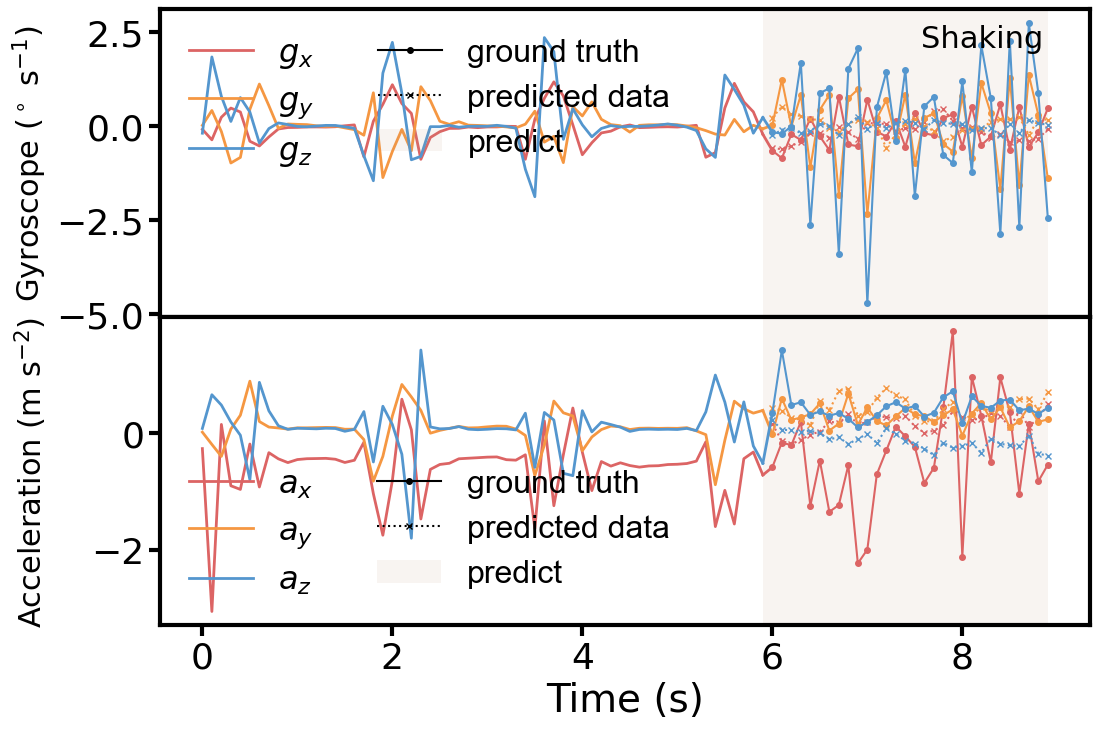

Loss: 1.0281267166137695
Grouped visualization for test sample index: 3


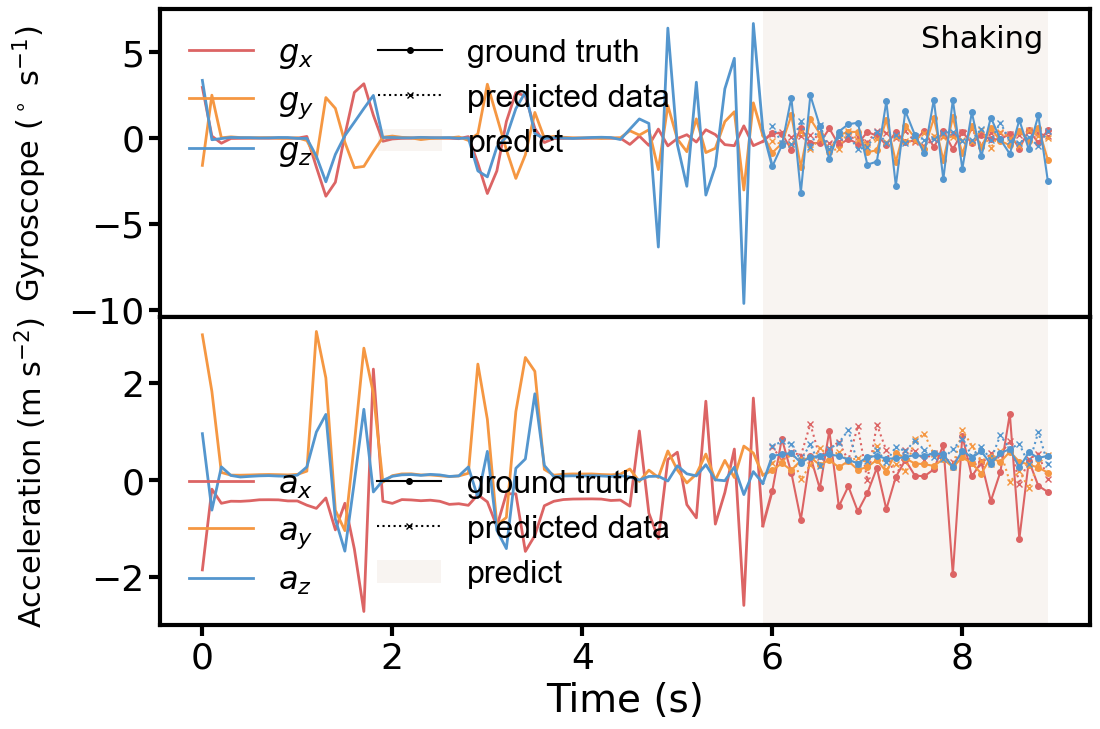

Loss: 0.936279833316803
Grouped visualization for test sample index: 4


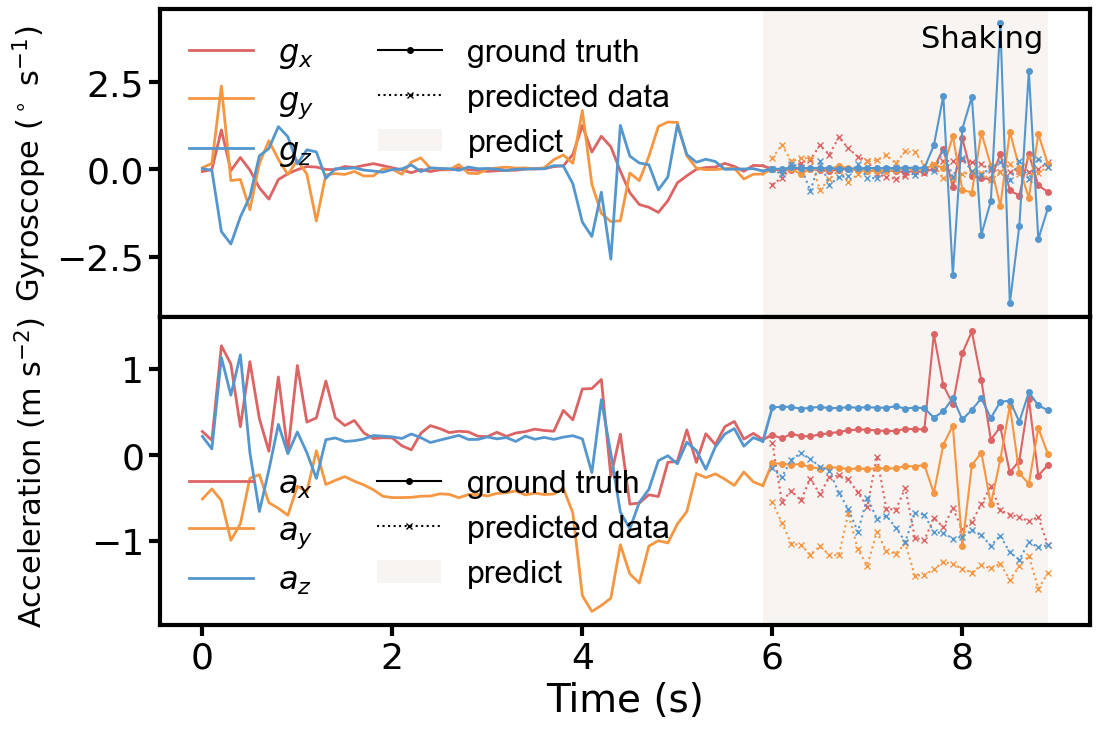

Loss: 1.1596577167510986
Grouped visualization for test sample index: 5


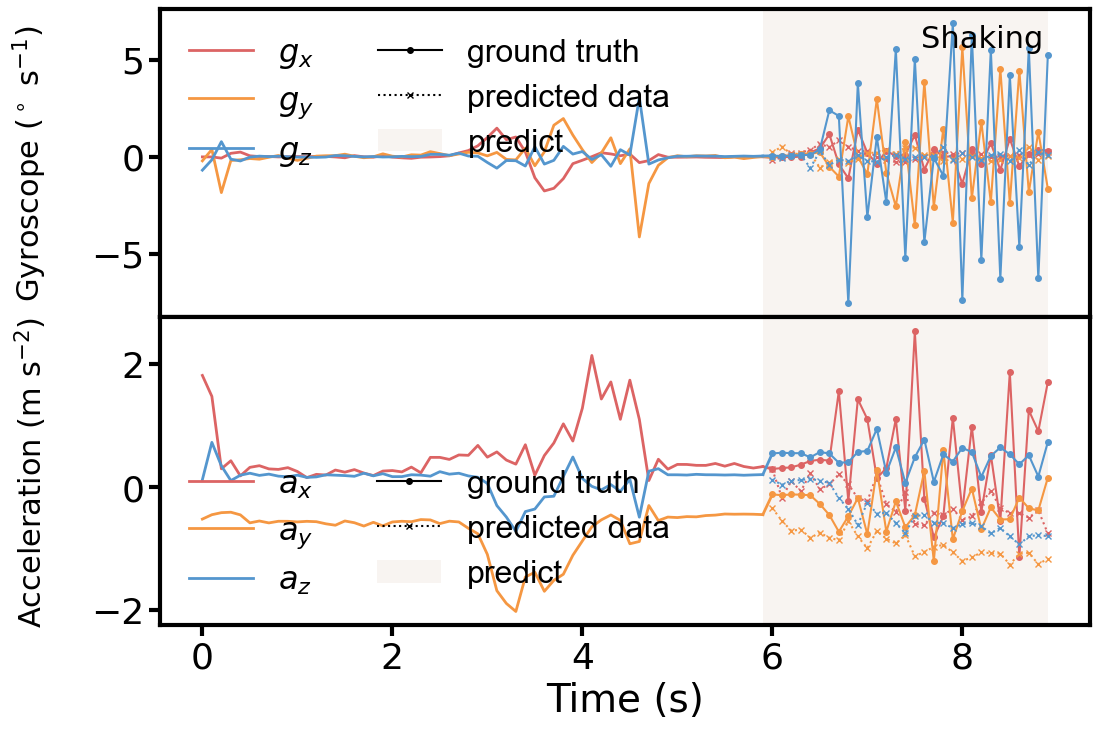

Loss: 4.862728595733643
Grouped visualization for test sample index: 6


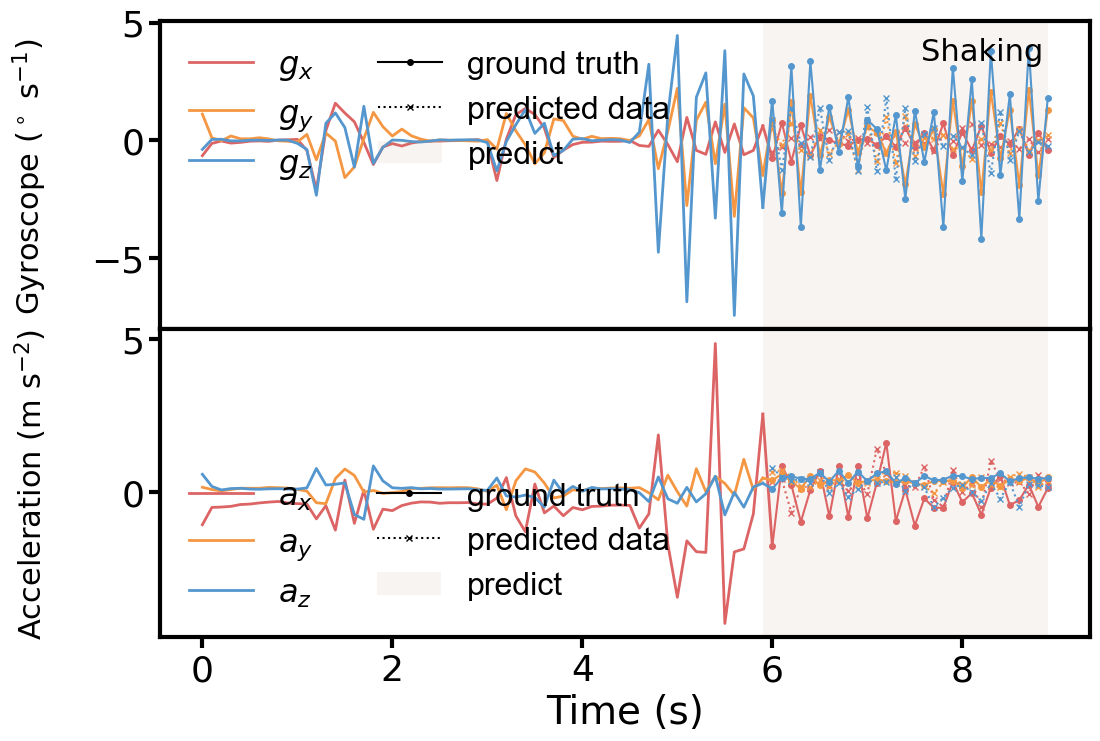

Loss: 1.9834942817687988
Grouped visualization for test sample index: 7


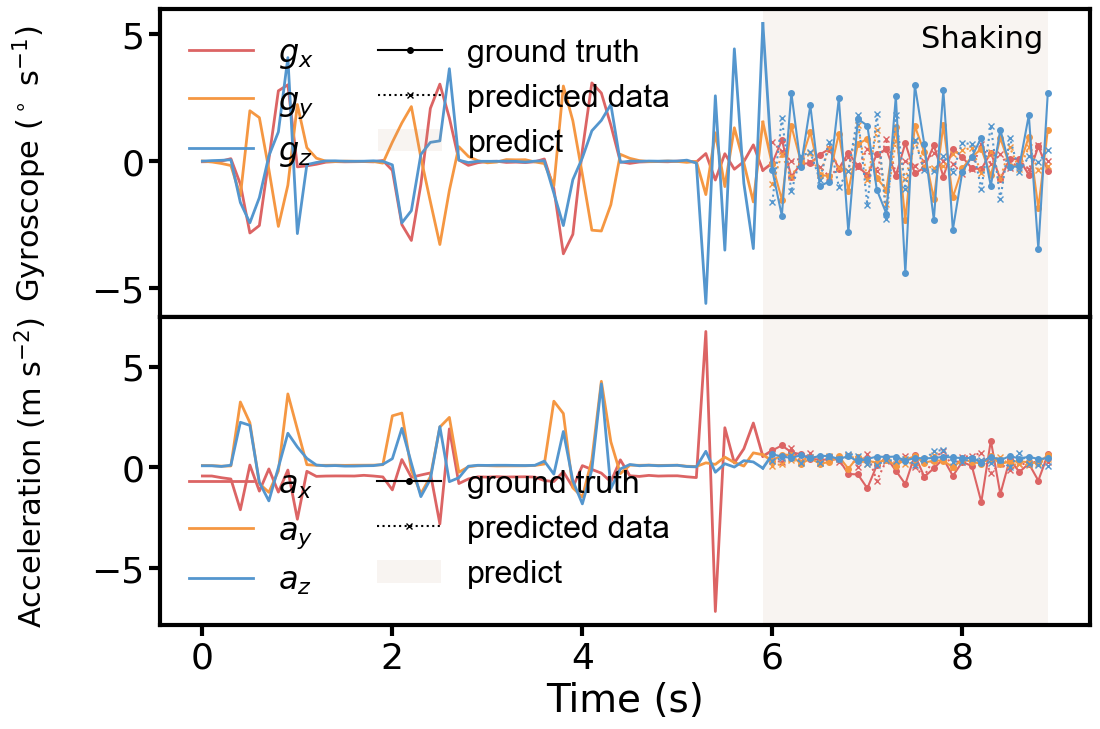

Loss: 1.222596526145935
Grouped visualization for test sample index: 8


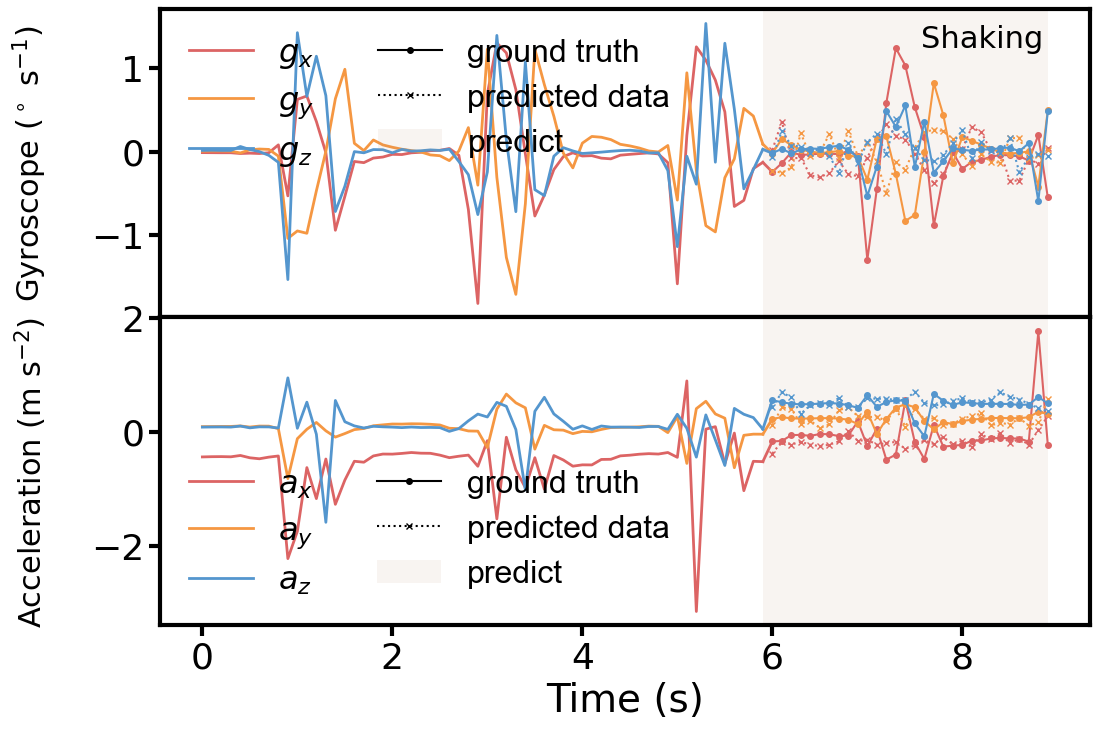

Loss: 0.1014707013964653
Grouped visualization for test sample index: 9


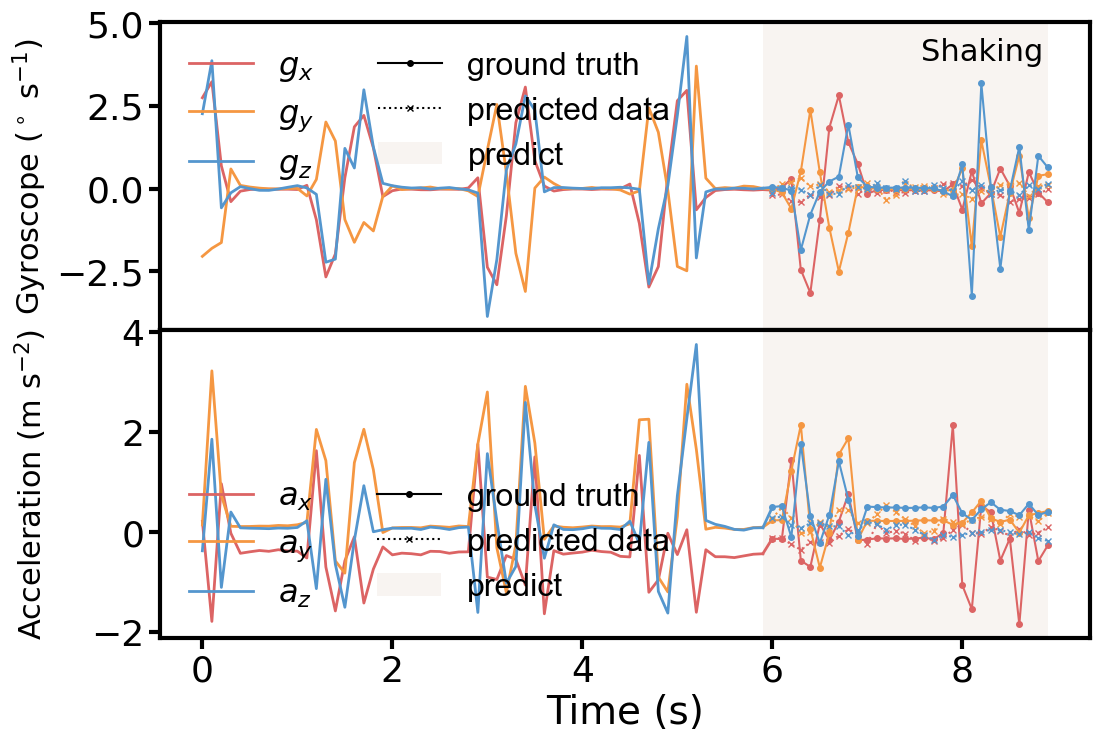

Loss: 0.7322888970375061
Grouped visualization for test sample index: 10


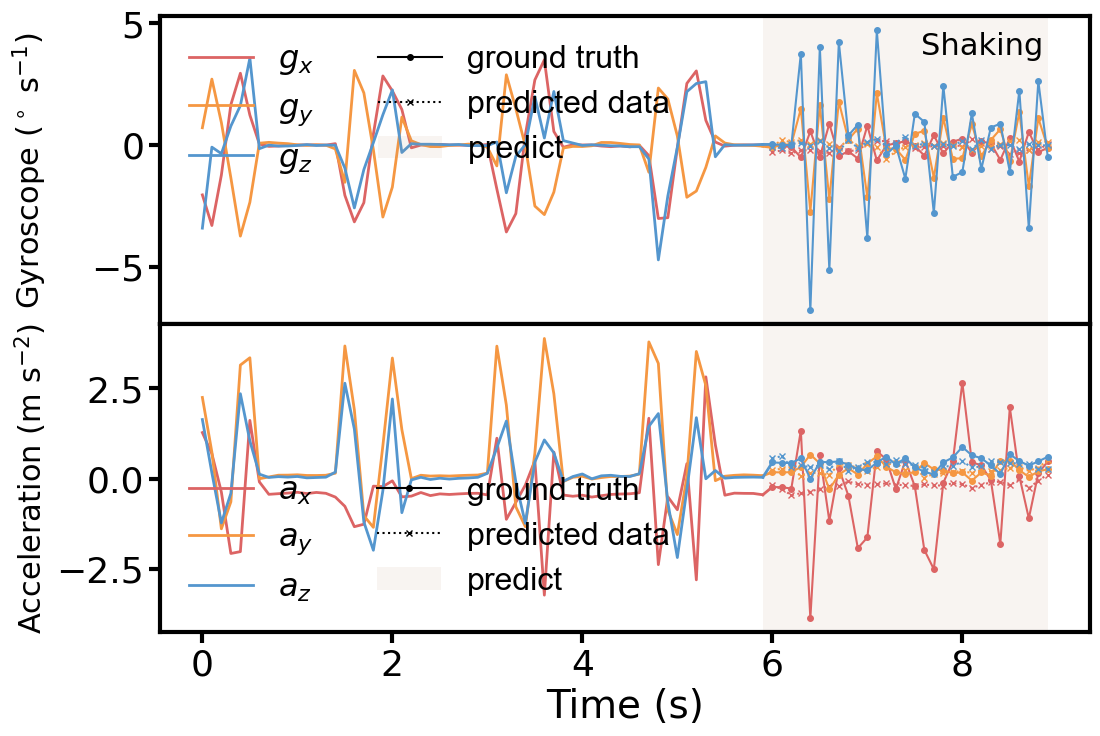

Loss: 1.725459337234497
Grouped visualization for test sample index: 11


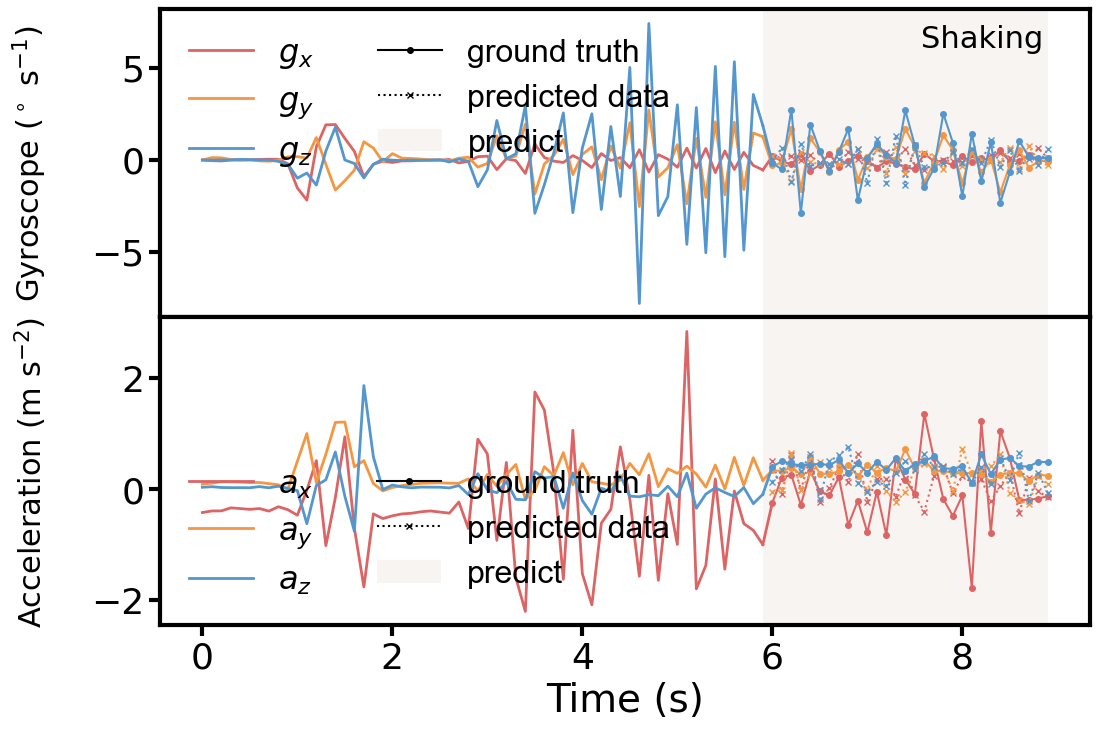

Loss: 0.8808113932609558
Grouped visualization for test sample index: 12


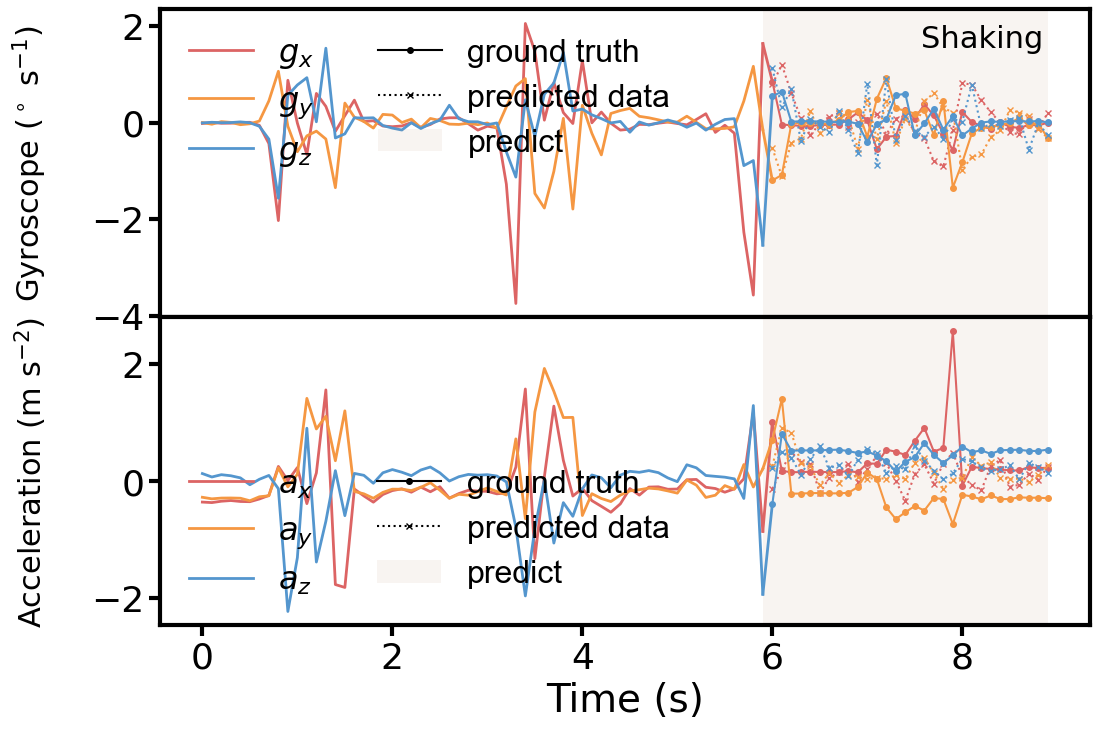

Loss: 0.22085851430892944
Grouped visualization for test sample index: 13


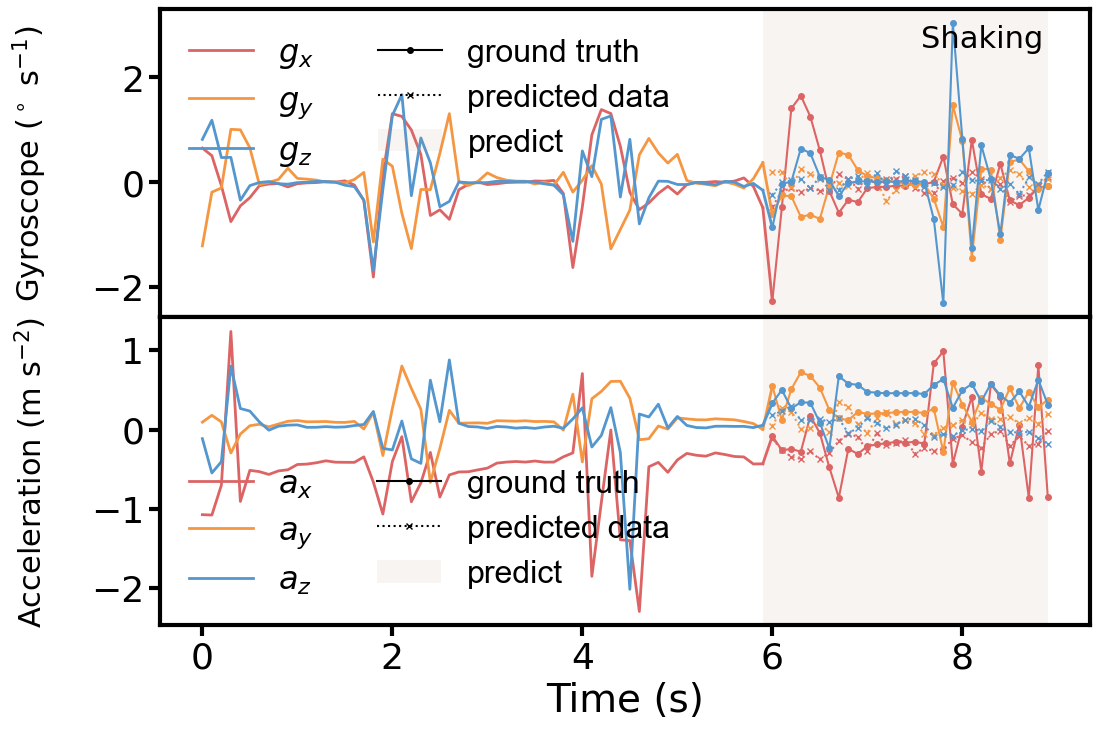

Loss: 0.34463196992874146
Grouped visualization for test sample index: 14


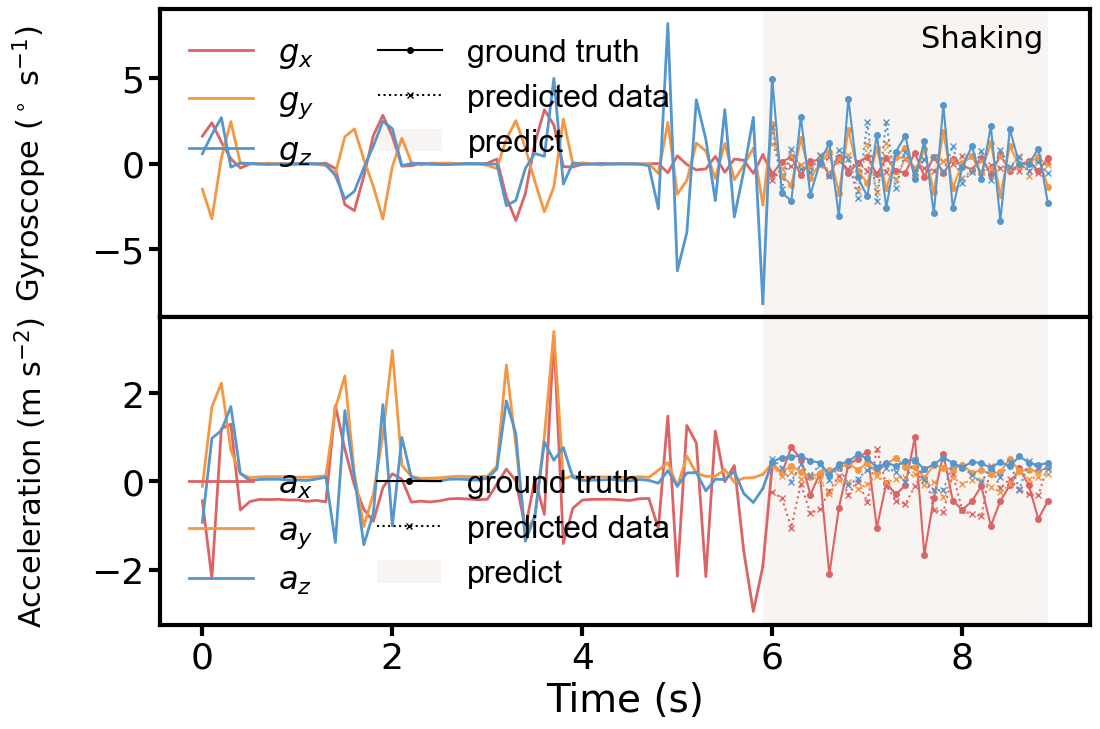

Loss: 1.7403324842453003
Grouped visualization for test sample index: 15


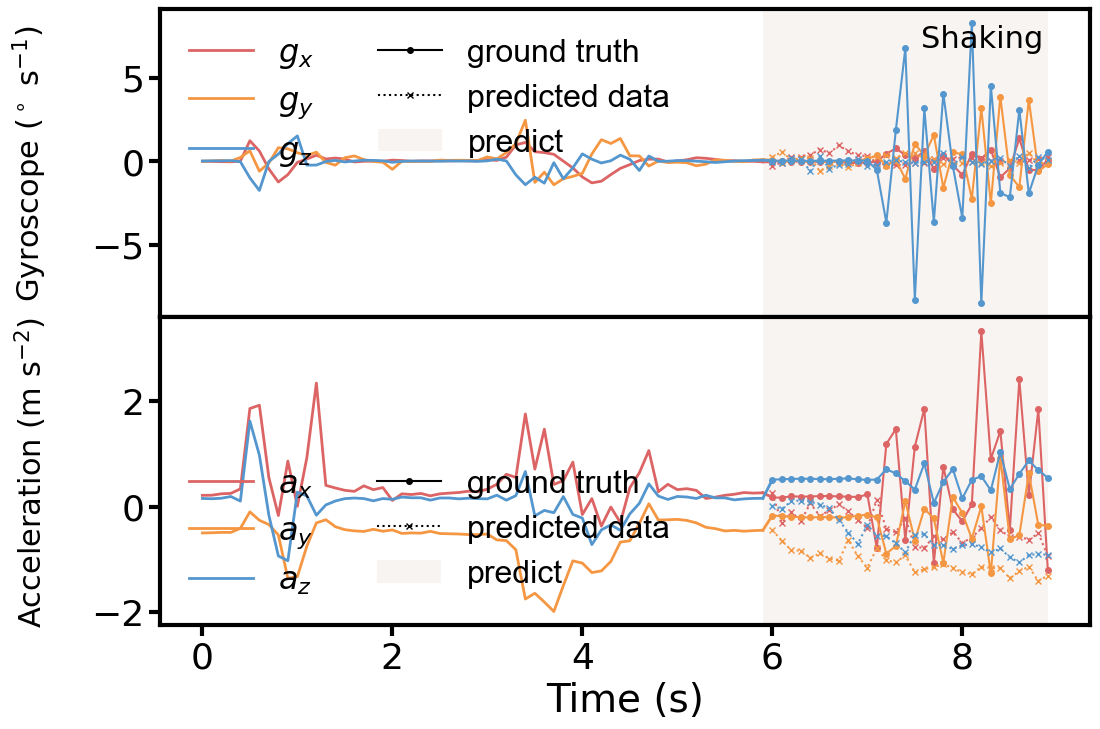

Loss: 3.0454468727111816
Grouped visualization for test sample index: 16


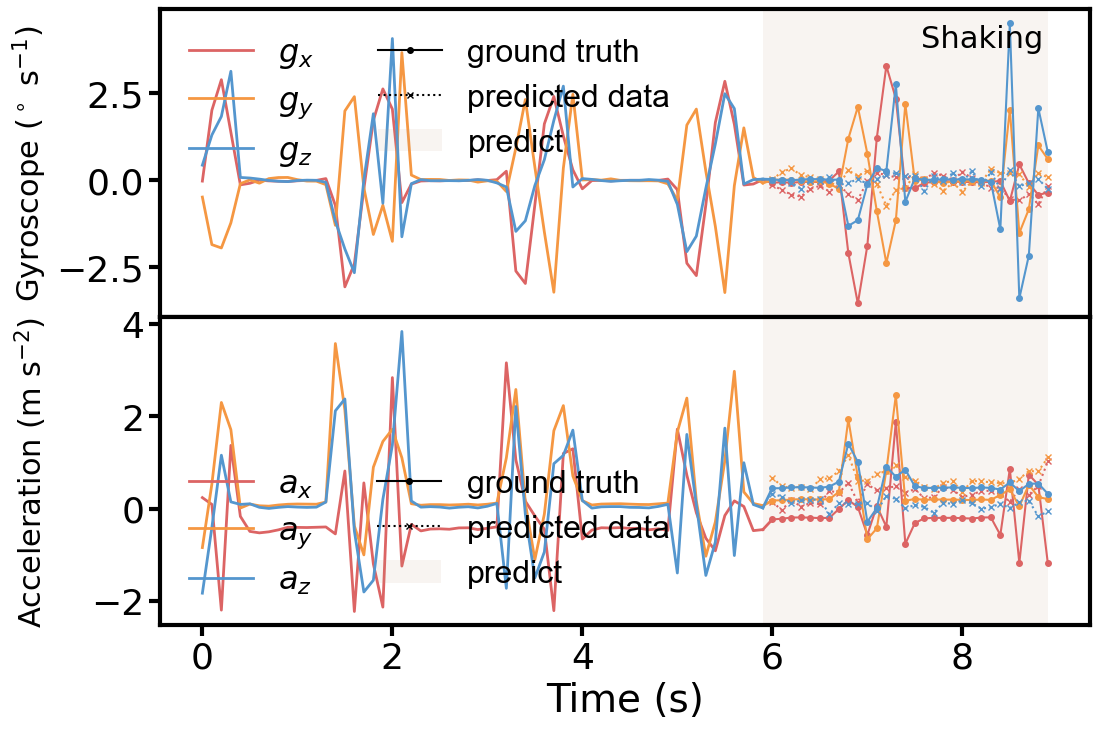

Loss: 0.7880198359489441
Grouped visualization for test sample index: 17


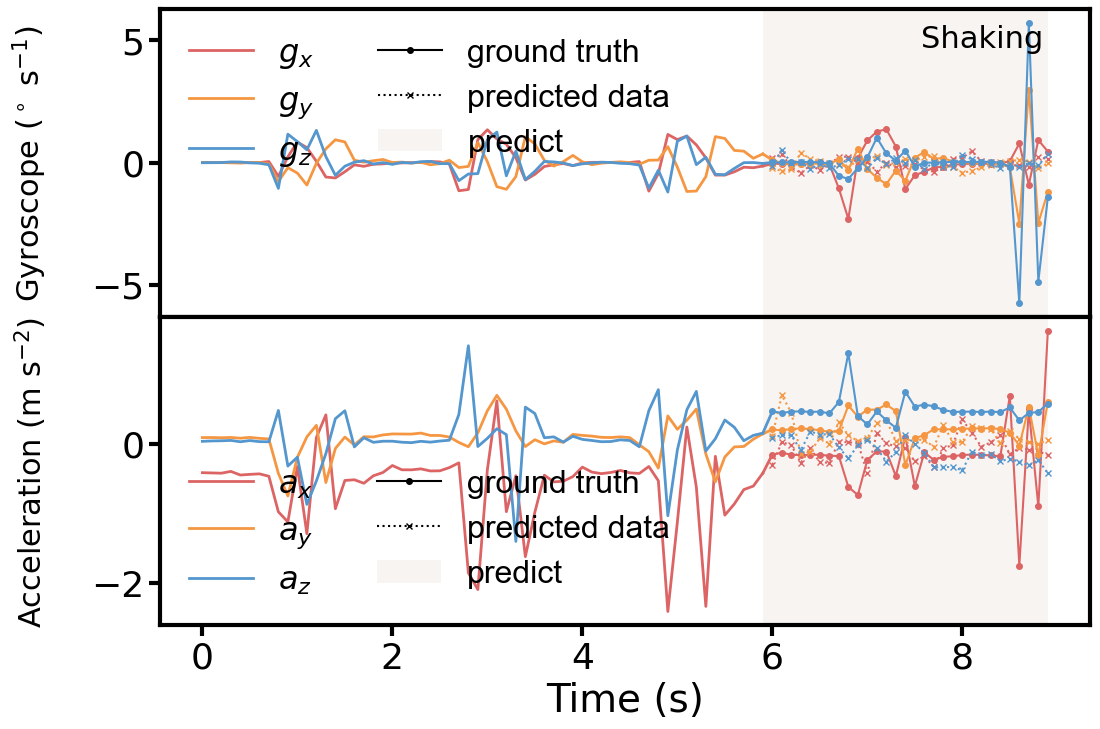

Loss: 0.8981353640556335
Grouped visualization for test sample index: 18


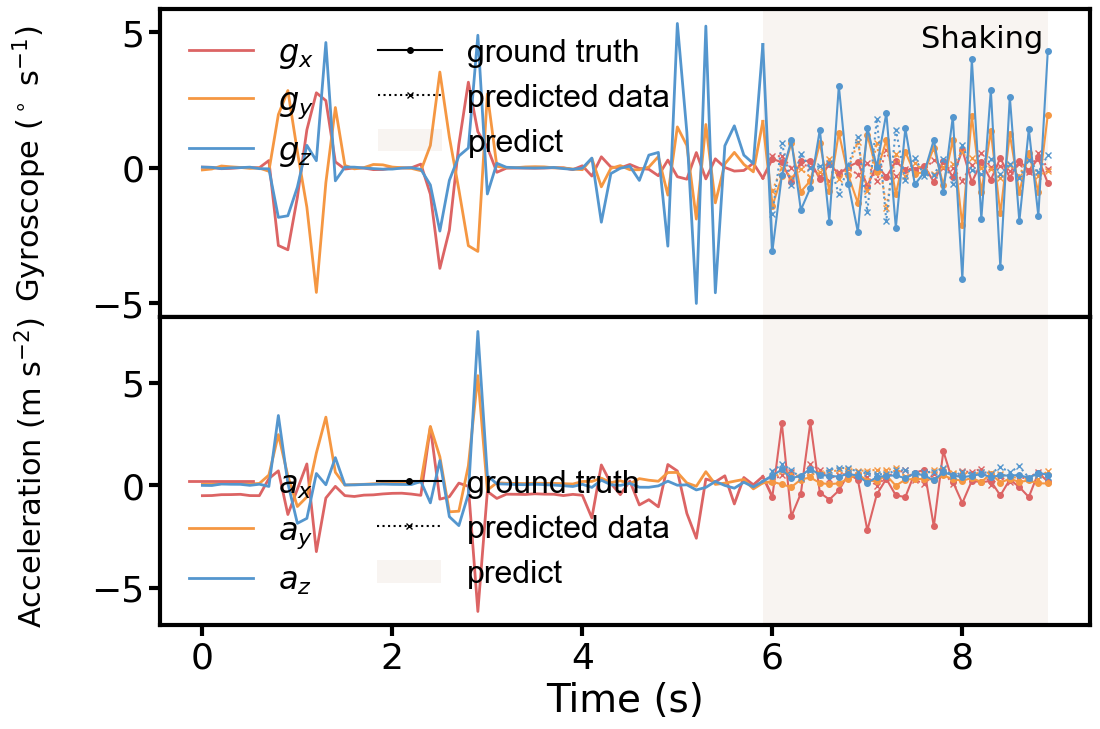

Loss: 1.6562901735305786
Grouped visualization for test sample index: 19


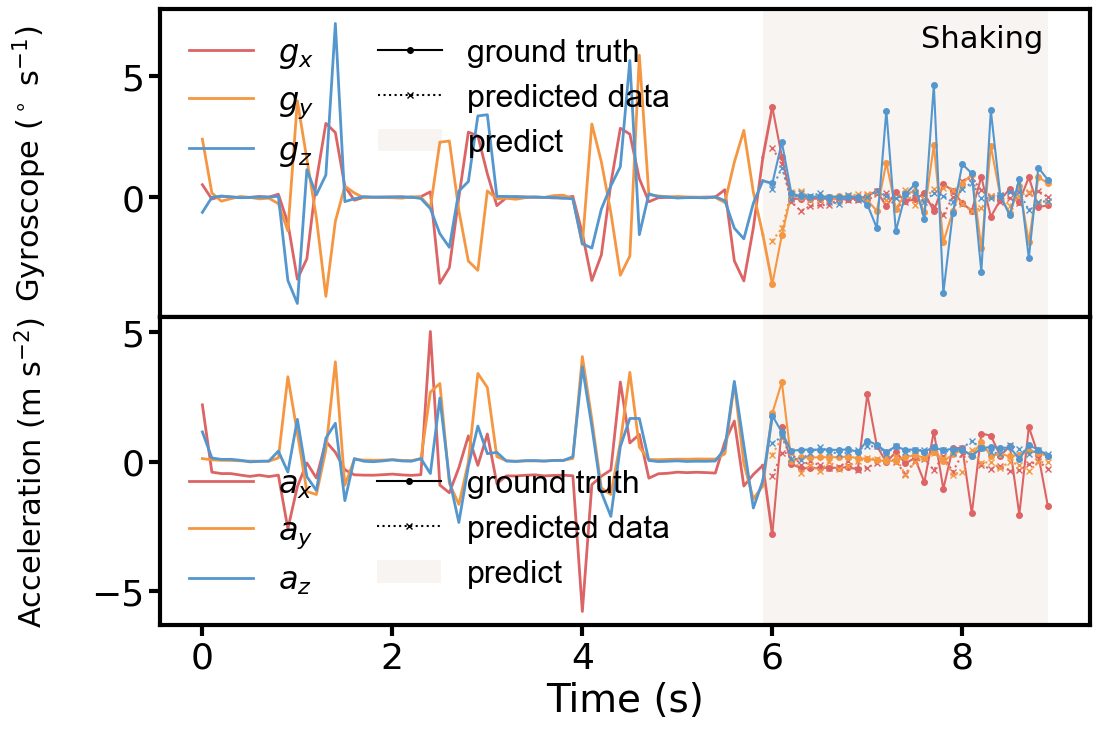

Loss: 1.0169377326965332
Grouped visualization for test sample index: 20


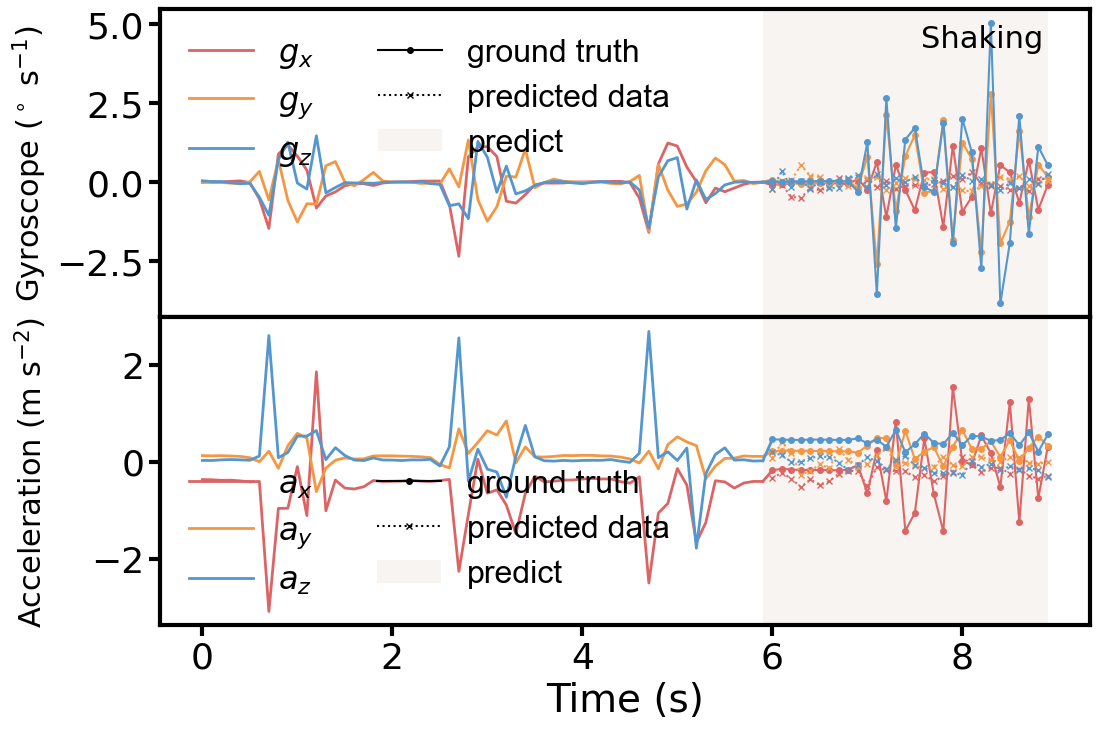

Loss: 1.0858311653137207
Grouped visualization for test sample index: 21


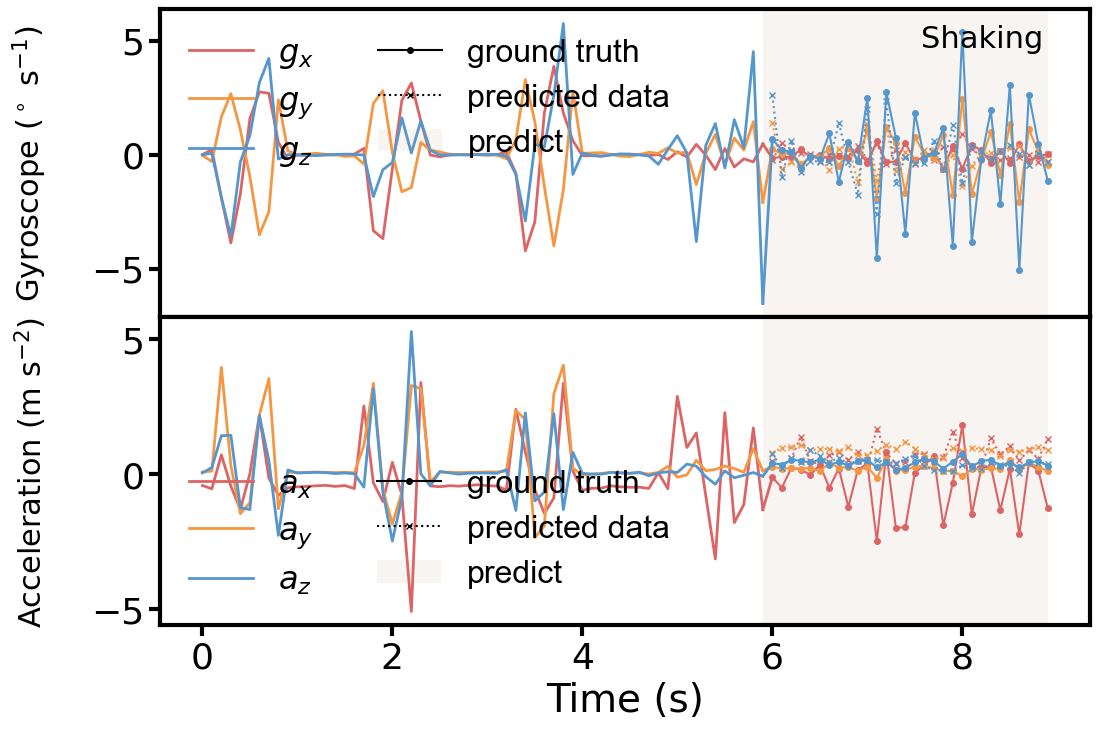

Loss: 1.8104026317596436
Grouped visualization for test sample index: 22


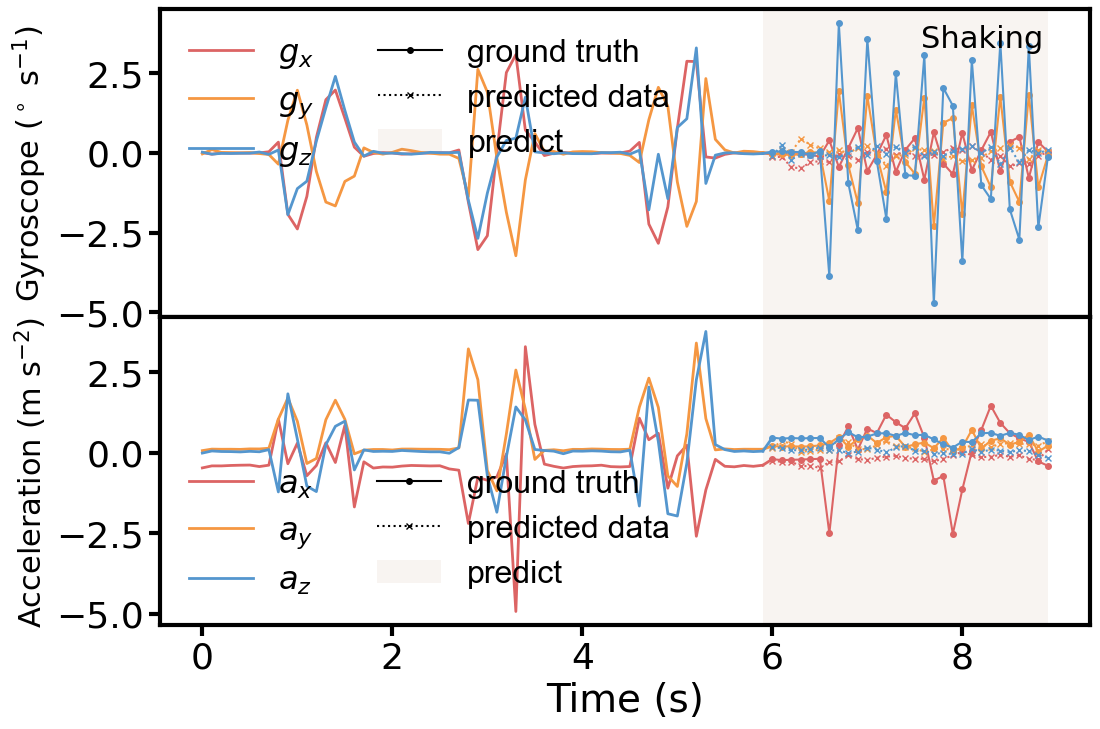

Loss: 1.416102647781372
Grouped visualization for test sample index: 23


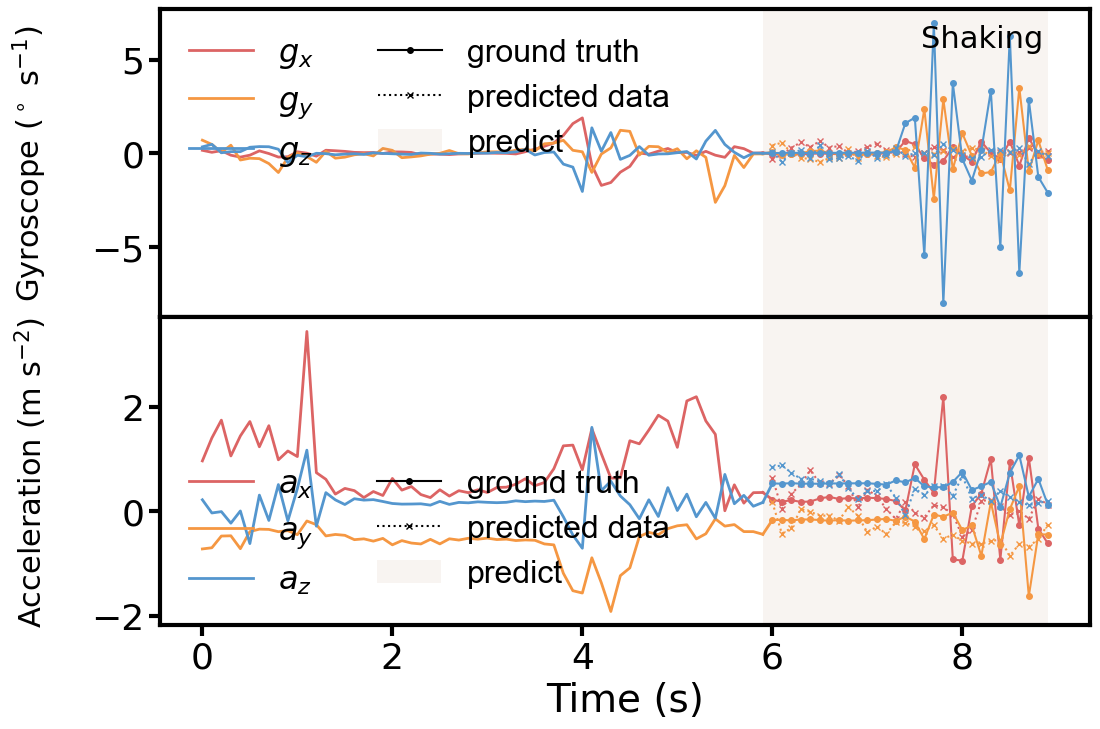

Loss: 2.1348507404327393
Grouped visualization for test sample index: 24


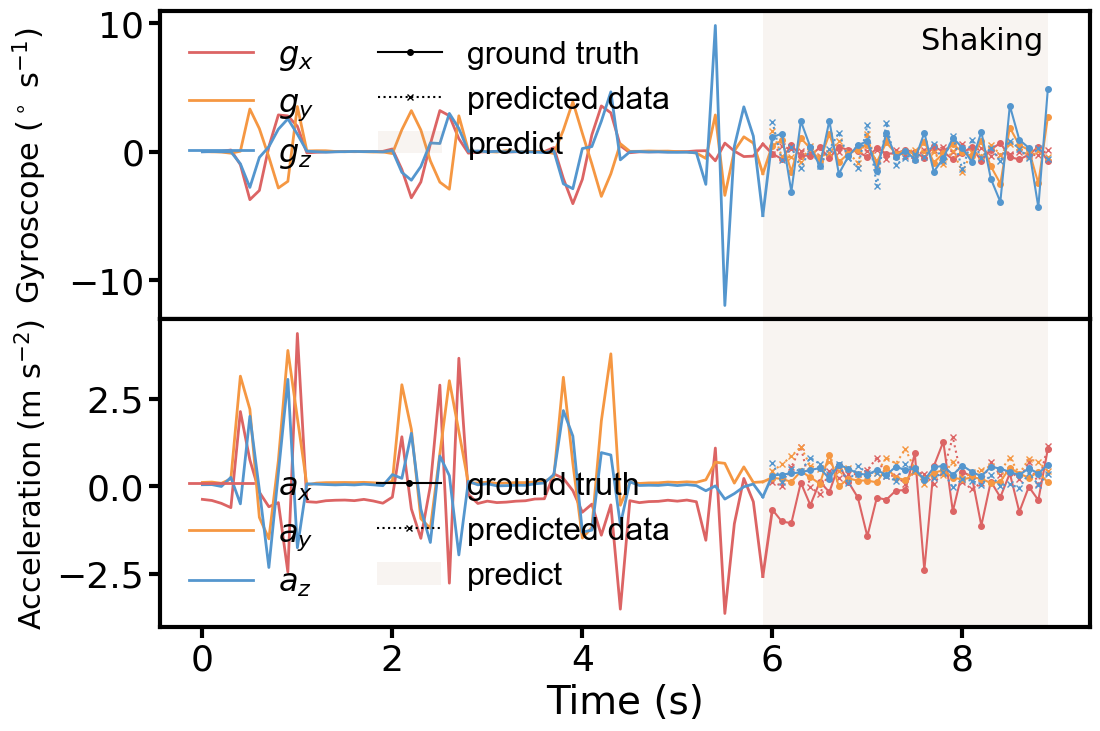

Loss: 1.3172476291656494
Grouped visualization for test sample index: 25


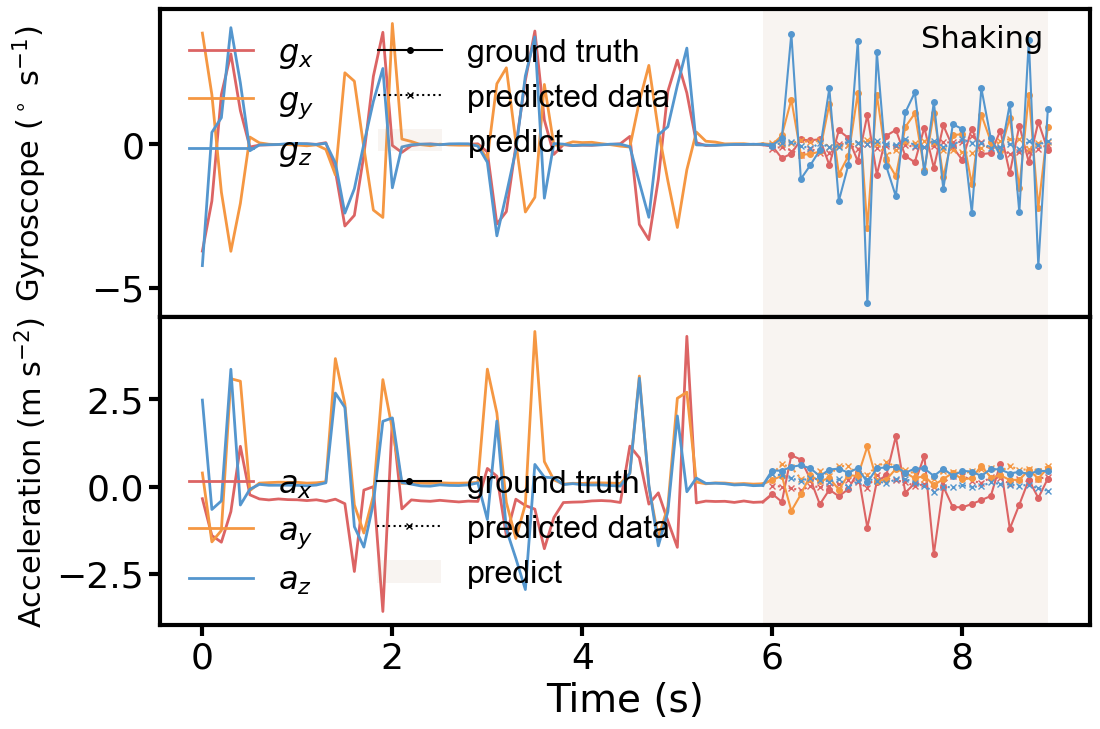

Loss: 1.1882436275482178
Grouped visualization for test sample index: 26


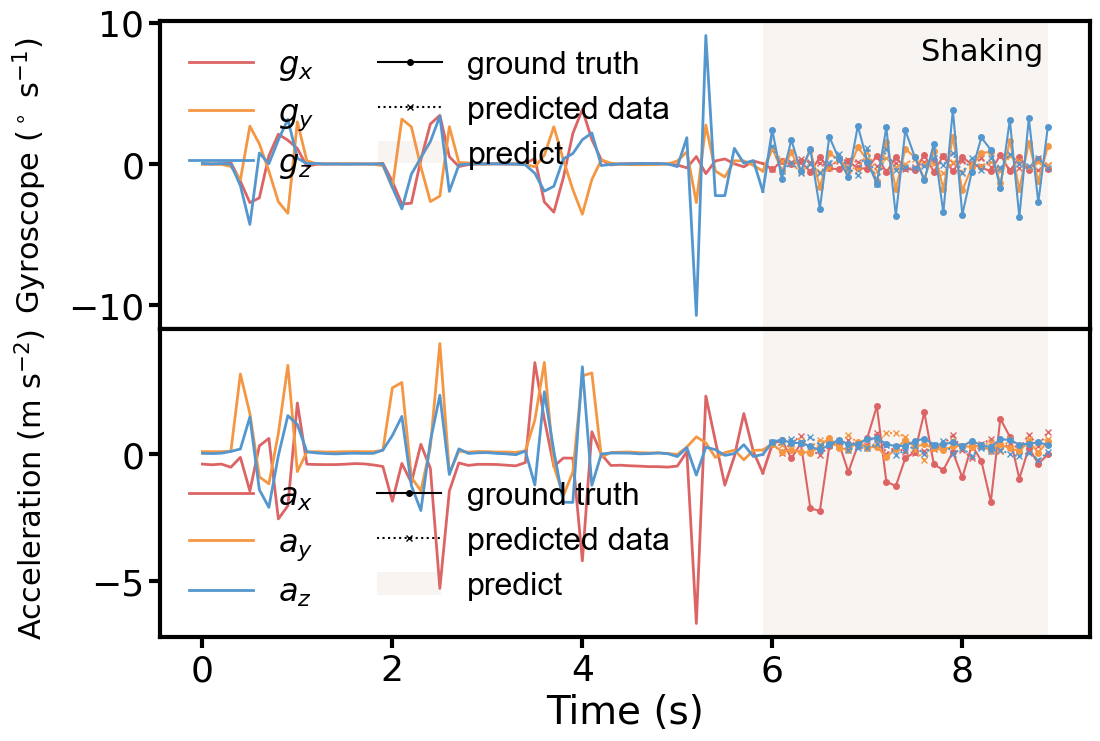

Loss: 1.220086693763733
Grouped visualization for test sample index: 27


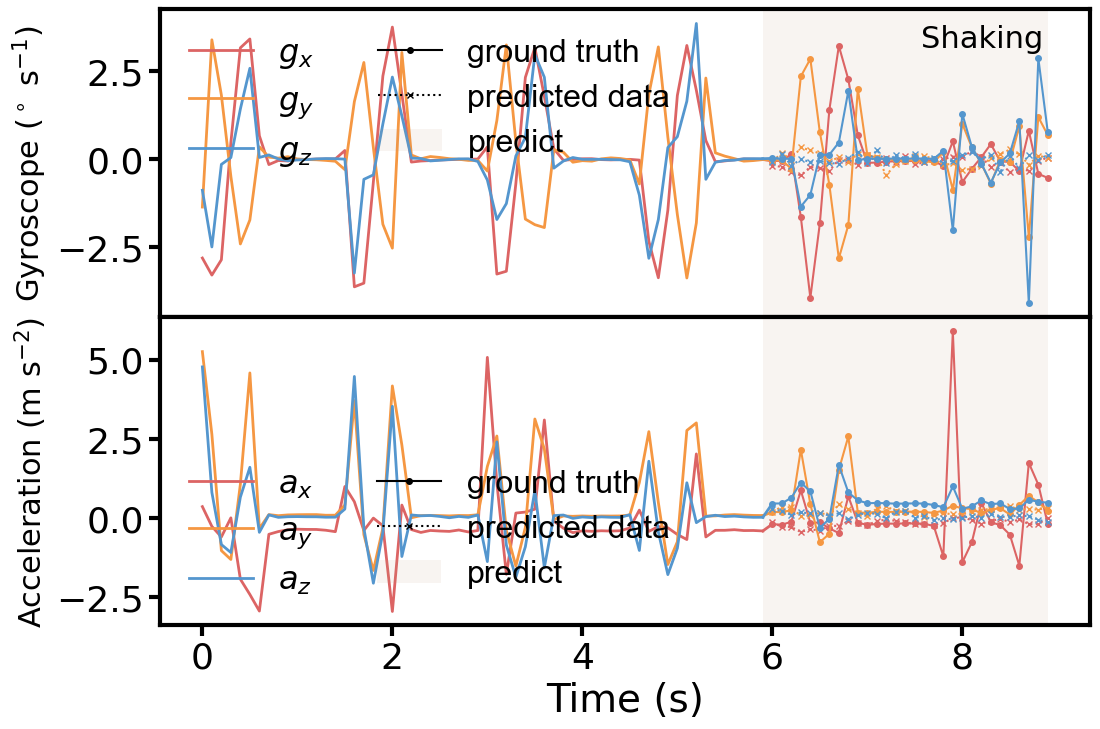

Loss: 1.0601450204849243


In [5]:

using_dataset = test_dataset
num_grouped_samples = len(using_dataset)
total_samples = len(using_dataset)
#grouped_random_indices = random.sample(range(total_samples), num_grouped_samples)

for idx in range(total_samples): #grouped_random_indices:
    print(f"Grouped visualization for test sample index: {idx}")
    sample = using_dataset[idx]  # sample returns (sample_X, sample_y, label)
    loss_value = visualize_new_grouped_sensors(sample, model, config, device)
    print(f"Loss: {loss_value}")